# Model definition

Below is an implementation of the [LeNet](https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html) architecture for the MNIST dataset.

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

In [0]:
# LeNet Model definition
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        
        return F.log_softmax(x, dim=1)

In [3]:
# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CUDA Available:  True


In [4]:
model = Net().to(device)
model

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [0]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./mnist', 
                   download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                   ])),
    batch_size=128, shuffle=True)

In [0]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()

# Use Stochastic Gradient Descent
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [7]:
epoch_num = 20
model.train()
for epoch in range(epoch_num):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()
        
        # Remember a line with model.to(device)?
        # It moves a model to a GPU and PyTorch expects that
        # input data also will be on the GPU where the model resides
        inputs, labels = inputs.to(device), labels.to(device)

        # forward + backward + optimize
        outputs = model(inputs)
        
        # Calculate the error between model predictins and actual labels
        loss = criterion(outputs, labels)
        
        # Initiate backward propagation
        loss.backward()
        
        # Update weights
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # print every 200 mini-batches
            print(f'[Epoch {epoch + 1}: batch {i + 1}] loss: {running_loss / 200}')
            running_loss = 0.0

print('Finished Training')

[Epoch 1: batch 200] loss: 2.2957795226573943
[Epoch 1: batch 400] loss: 2.2577357006073
[Epoch 2: batch 200] loss: 1.8755371963977814
[Epoch 2: batch 400] loss: 1.3234312951564788
[Epoch 3: batch 200] loss: 0.9713010323047638
[Epoch 3: batch 400] loss: 0.8537770050764084
[Epoch 4: batch 200] loss: 0.7454489383101464
[Epoch 4: batch 400] loss: 0.695138503909111
[Epoch 5: batch 200] loss: 0.6250861445069313
[Epoch 5: batch 400] loss: 0.5931834580004215
[Epoch 6: batch 200] loss: 0.557743929028511
[Epoch 6: batch 400] loss: 0.5394540971517563
[Epoch 7: batch 200] loss: 0.5102759525179863
[Epoch 7: batch 400] loss: 0.4954481887817383
[Epoch 8: batch 200] loss: 0.47052249401807783
[Epoch 8: batch 400] loss: 0.45982856914401055
[Epoch 9: batch 200] loss: 0.436388581097126
[Epoch 9: batch 400] loss: 0.42867075458168985
[Epoch 10: batch 200] loss: 0.4153003612160683
[Epoch 10: batch 400] loss: 0.41159209705889227
[Epoch 11: batch 200] loss: 0.39767999030649664
[Epoch 11: batch 400] loss: 0.39

Let's check how accurate is our network

In [0]:
data_test = datasets.MNIST('./mnist',
                           train=False,
                           download=True,
                           transform=transforms.Compose([
                               transforms.ToTensor(),
                           ]))

test_loader = torch.utils.data.DataLoader(data_test, batch_size=256)

In [9]:
# Prevent training
model.eval()

total_correct = 0
avg_loss = 0.0

for i, data in enumerate(test_loader, 0):
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
   
    output = model(inputs)
    avg_loss += criterion(output, labels).sum()
    
    # tensor.detach() creates a tensor that shares storage with tensor that does not require grad.
    # It detaches the output from the computational graph.
    # So no gradient will be backpropagated along this variable.
    pred = output.detach().max(1)[1]
    total_correct += pred.eq(labels.view_as(pred)).sum()

avg_loss /= len(data_test)
avg_loss = avg_loss.detach().cpu().item()
accuracy = float(total_correct) / len(data_test)
print(f'Test Avg. Loss: {avg_loss}, Accuracy: {accuracy}')


Test Avg. Loss: 0.0004431374545674771, Accuracy: 0.963


# FGSM Attack

The fgsm_attack function takes three inputs: image is the original clean image (x), epsilon is the pixel-wise perturbation amount (ϵ), and data_grad is gradient of the loss w.r.t the input image.

The function then creates perturbed image as

$$\text{perturbed image} = image + epsilon * sign(gradient) = x + ϵ ∗ sign(∇xJ(θ,x,y))$$

In [0]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon * sign_data_grad
    
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    
    # Return the perturbed image
    return perturbed_image

# PRACTICUM TASK

In [0]:
# change batch size
data_test = datasets.MNIST('./mnist',
                           train=False,
                           download=True,
                           transform=transforms.Compose([
                               transforms.ToTensor(),
                           ]))

test_loader = torch.utils.data.DataLoader(data_test, batch_size=1)

## Task 1

1 - For each class select 10 images not from this class. Perform attack to move selected images to this class. for each class select image with highest confidence.


Best sample is the one with higher confidence.

Since the output is $log(softmax)$, we will take $exp(output)$ as a confidence.

In [0]:
def targeted_attack(image, epsilon, data_grad):

    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image - epsilon * data_grad
    
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    
    # Return the perturbed image
    return perturbed_image

In [0]:
def test_targeted(model, device, test_loader, epsilon, target_label):

    # Accuracy counter
    correct = 0

    # Examples
    adv_examples = [0]*10
    confidences = np.zeros((10,))
    confidences[target_label] = -1 # to identify a target if you forgot :]

    # count adversarial attacks success per each class
    adv_count = np.zeros((10,))
    adv_count[target_label] = -1 # to identify a target if you forgot :]


    # Modify target label
    target_label = torch.full((1,), target_label, dtype=torch.long, device=device)

    for data, target in test_loader:

        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate targeted loss
        loss = F.nll_loss(output, target_label)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call Attack Function
        perturbed_data = targeted_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        elif final_pred.item() == target_label.item():
            adv_count[target.item()] += 1
            # Save best adv examples for visualization later
            correct_label = target.item()
            confidence = torch.exp(output[0, target_label.item()])
            if  confidence > confidences[correct_label]:
                confidences[correct_label] = confidence
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples[correct_label] = (init_pred.item(), confidence, adv_ex) 

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Show adversarial success per class + fail
    if eps != 0:
        for cls in range(adv_count.shape[0]):
            if cls == target_label.item():
                continue
            print(f"Succeed {adv_count[cls]} with digit {cls}")

    # Return the accuracy and an adversarial example
    return final_acc, adv_count, adv_examples

In [14]:
accuracies = []
examples = []

target_label = 0

# Epsilon 0 means no attack at all
epsilons = [ .05, .1, .2, .4]

# Run test for each epsilon
for eps in epsilons:
    acc, adv, ex = test_targeted(model, device, test_loader, eps, target_label)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0.05	Test Accuracy = 9599 / 10000 = 0.9599
Succeed 0.0 with digit 1
Succeed 0.0 with digit 2
Succeed 0.0 with digit 3
Succeed 0.0 with digit 4
Succeed 1.0 with digit 5
Succeed 1.0 with digit 6
Succeed 0.0 with digit 7
Succeed 1.0 with digit 8
Succeed 1.0 with digit 9
Epsilon: 0.1	Test Accuracy = 9549 / 10000 = 0.9549
Succeed 0.0 with digit 1
Succeed 2.0 with digit 2
Succeed 0.0 with digit 3
Succeed 0.0 with digit 4
Succeed 1.0 with digit 5
Succeed 2.0 with digit 6
Succeed 0.0 with digit 7
Succeed 3.0 with digit 8
Succeed 1.0 with digit 9
Epsilon: 0.2	Test Accuracy = 9287 / 10000 = 0.9287
Succeed 0.0 with digit 1
Succeed 6.0 with digit 2
Succeed 3.0 with digit 3
Succeed 2.0 with digit 4
Succeed 5.0 with digit 5
Succeed 13.0 with digit 6
Succeed 3.0 with digit 7
Succeed 11.0 with digit 8
Succeed 3.0 with digit 9
Epsilon: 0.4	Test Accuracy = 7904 / 10000 = 0.7904
Succeed 1.0 with digit 1
Succeed 24.0 with digit 2
Succeed 11.0 with digit 3
Succeed 24.0 with digit 4
Succeed 30.0 wi

In [0]:
# Plot several examples of adversarial samples precised epsilon
def plot_examples(examples, target_label, title=None):
    ex_copy = examples[:]
    del ex_copy[target_label]

    fig, ax = plt.subplots(3,3, figsize=(8,10))
    if title is not None:
        fig.suptitle(title)

    positions = np.indices((3,3)).reshape(2,9)
    for i, example in enumerate(ex_copy):
        j = positions[0, i]
        k = positions[1, i]
        try:
            orig, cnf, ex = example 
            ax[j,k].imshow(ex, cmap="gray")
            ax[j,k].set_title("True {} -> Adv 0: {:.2f}".format(orig, cnf.item()))
        except TypeError:
           # it means we have 0 instead of a tuple
           # which indicates we haven't got any successful adversaries on this digit
           ax[j,k].plot(np.arange(0,28,1), np.arange(0,28,1))
           ax[j,k].set_title("No adv for this digit".format())
    # plt.tight_layout()
    fig.show()

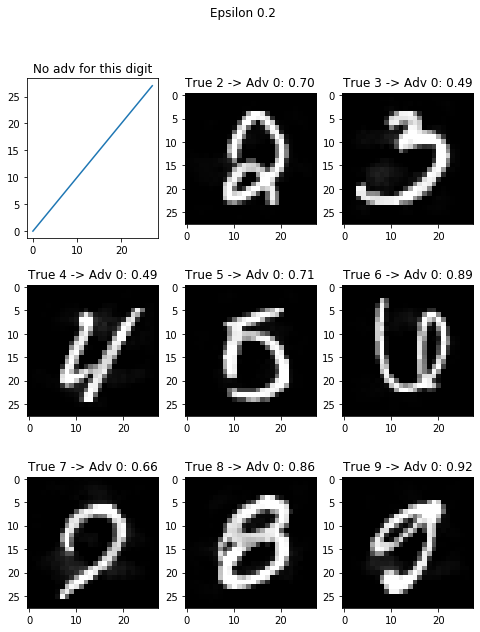

In [16]:
title = f"Epsilon {epsilons[-2]}"
plot_examples(examples[-2], target_label, title=title)

## Task 2
2 - Try different epsilons for one selected class and collect the number of iterations required to achieve success

In [0]:
def targeted_fsgm(image, epsilon, data_grad):  
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()

    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image - epsilon * sign_data_grad
    
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    
    # Return the perturbed image
    return perturbed_image

In [0]:
def one_class_targeting(model, device, 
                        test_loader, epsilon, 
                        target_label, selected_class,
                        sample_size=100):

    # Modify target label
    target_label = torch.full((1,), target_label, dtype=torch.long, device=device)

    # Number of iterations count
    total_iter_num = []
    correct_iter_num = []

    # Initialize max confidence for getting an example
    max_conf = 0

    for data, target in test_loader:
        # Control sample size
        if len(total_iter_num) >= sample_size:
            break

        # Get data
        data, target = data.to(device), target.to(device)
        
        # We will work with only one class, others are dismissed
        if target.item() != selected_class:
            continue

        # Get correct output
        with torch.no_grad():
            output = model(data)
            init_pred = output.max(1, keepdim=True)[1]
            if init_pred.item() != target.item():
                continue

        # Get number of iterations for current image
        total_iterations = 0
        # correct=1, 'cause we should iterate at least once to get the gradient
        correct_iterations = 1 
        succeed = False
        while not succeed:
            # iterations count
            total_iterations += 1

            # get gradient
            data.requires_grad = True
            output = model(data)
            init_pred = output.max(1, keepdim=True)[1]
            loss = F.nll_loss(output, target_label)  # targeted loss
            model.zero_grad()
            loss.backward()
            data_grad = data.grad.data

            # modify image
            perturbed_data = targeted_fsgm(data, epsilon, data_grad)

            # reclassify image
            output = model(perturbed_data)

            # check for success
            final_pred = output.max(1, keepdim=True)[1]
            if final_pred.item() == target.item():
                correct_iterations += 1
            elif final_pred.item() == target_label.item():
                succeed = True
                # Save best adv examples for visualization
                correct_label = target.item()
                confidence = torch.exp(output[0, target_label.item()])
                if  confidence > max_conf:
                    max_conf = confidence
                    adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                    adv_example = (confidence, adv_ex) 

            data.data = perturbed_data.clone()

    # Save iteration number
    total_iter_num.append(total_iterations)
    correct_iter_num.append(correct_iterations)

    # Return two medians + example
    return np.median(total_iter_num), np.median(correct_iter_num), adv_example


In [19]:
examples = []

target_label = 0
target_class = 1

# Epsilon 0 means no attack at all
epsilons = [ .05, .1, .2]

# Run test for each epsilon
for eps in epsilons:
    total, correct, ex = one_class_targeting(
        model, device, 
        test_loader, eps, 
        target_label, target_class,
        sample_size=200
        )
    examples.append(ex)
    print(f"Epsilon {eps}:")
    print(f"Total iterations median: {total}")
    print(f"Times classified correctly: {correct}")

Epsilon 0.05:
Total iterations median: 9.0
Times classified correctly: 5.0
Epsilon 0.1:
Total iterations median: 5.0
Times classified correctly: 3.0
Epsilon 0.2:
Total iterations median: 3.0
Times classified correctly: 2.0


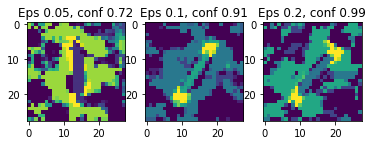

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=len(epsilons))
for i, ex in enumerate(examples):
    conf, img = ex
    ax[i].imshow(img)
    ax[i].set_title("Eps {}, conf {:.2f}".format(epsilons[i], conf))